In [48]:
"""Preprocesamiento de datos de emisiones de gases de efecto invernadero."""
import rasterio
import importlib
from rasterio.mask import mask
import geopandas as gpd
import constants as c
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

importlib.reload(c)

<module 'constants' from 'c:\\Users\\Fabrizio\\Documents\\02 facu\\matematica-4\\misiones_carbon_analysis\\src\\misiones_carbon_analysis\\constants.py'>

In [3]:
# Cargar el shapefile de los límites de Misiones
misiones = gpd.read_file(c.PROVINCE_SHAPE_PATH)
misiones = misiones[misiones["nam"] == "Misiones"]

# Abrir el archivo GeoTIFF
with rasterio.open(c.ARGENTINA_TIFF_PATH) as src:
    terrain_image, terrain_transform = mask(src, misiones.geometry, crop=True)
    terrain_meta = src.meta.copy()

with rasterio.open(c.MISIONES_COVER_TIFF_PATH) as src:
    cover_image, cover_transform = mask(src, misiones.geometry, crop=True)
    cover_meta = src.meta.copy()

with rasterio.open(c.MISIONES_GAIN_TIFF_PATH) as src:
    gain_image, gain_transform = mask(src, misiones.geometry, crop=True)
    gain_meta = src.meta.copy()

with rasterio.open(c.MISIONES_LOSS_TIFF_PATH) as src:
    loss_image, loss_transform = mask(src, misiones.geometry, crop=True)
    loss_meta = src.meta.copy()
    
# Actualizar los metadatos
terrain_meta.update({
    "driver": "GTiff",
    "height": terrain_image.shape[1],
    "width": terrain_image.shape[2],
    "transform": terrain_transform
})

cover_meta.update({
    "driver": "GTiff",
    "height": cover_image.shape[1],
    "width": cover_image.shape[2],
    "transform": cover_transform
})

gain_meta.update({
    "driver": "GTiff",
    "height": gain_image.shape[1],
    "width": gain_image.shape[2],
    "transform": gain_transform
})

loss_meta.update({
    "driver": "GTiff",
    "height": loss_image.shape[1],
    "width": loss_image.shape[2],
    "transform": loss_transform
})


# Guardar el resultado
with rasterio.open("data/misiones_terrain.tif", "w", **cover_meta) as dest:
    dest.write(terrain_image)

with rasterio.open("data/misiones_cover.tif", "w", **cover_meta) as dest:
    dest.write(cover_image)

with rasterio.open("data/misiones_gain.tif", "w", **gain_meta) as dest:
    dest.write(gain_image)

with rasterio.open("data/misiones_loss.tif", "w", **loss_meta) as dest:
    dest.write(loss_image)


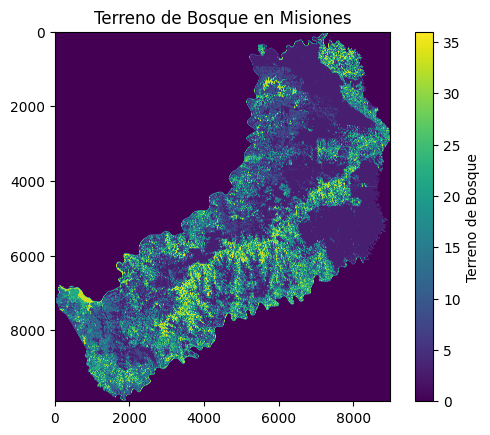

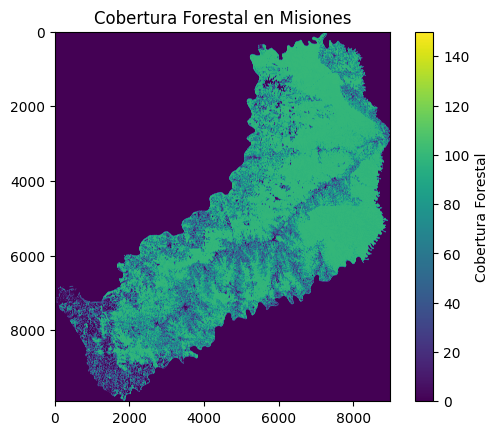

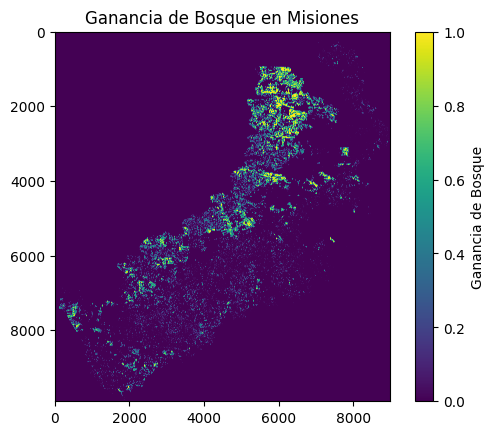

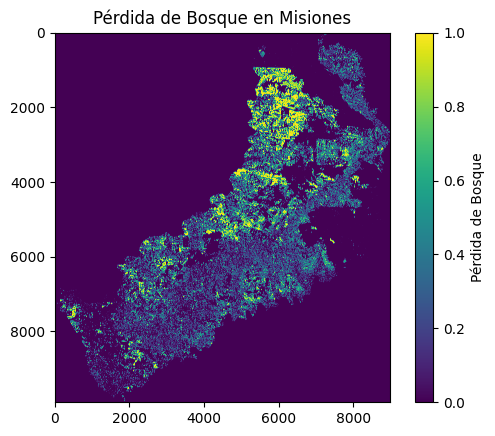

In [19]:
with rasterio.open("data/misiones_terrain.tif") as src:
    terrain = src.read(1)  # Leer la primera banda

plt.imshow(terrain)
plt.colorbar(label="Terreno de Bosque")
plt.title("Terreno de Bosque en Misiones")
plt.show()

with rasterio.open("data/misiones_cover.tif") as src:
    cover = src.read(1)  # Leer la primera banda

plt.imshow(cover, cmap="viridis", vmin=0, vmax=150)
plt.colorbar(label="Cobertura Forestal")
plt.title("Cobertura Forestal en Misiones")
plt.show()

with rasterio.open("data/misiones_gain.tif") as src:
    gain = src.read(1)  # Leer la primera banda

plt.imshow(gain)
plt.colorbar(label="Ganancia de Bosque")
plt.title("Ganancia de Bosque en Misiones")
plt.show()

with rasterio.open("data/misiones_loss.tif") as src:
    loss = src.read(1)  # Leer la primera banda

plt.imshow(loss)
plt.colorbar(label="Pérdida de Bosque")
plt.title("Pérdida de Bosque en Misiones")
plt.show()

In [105]:
treecover_loss_ha = pd.read_csv("../raw_data/gfw/treecover_loss__ha.csv", sep=",")
treecover_loss_ha.rename(columns={"umd_tree_cover_loss__year": "year", "umd_tree_cover_loss__ha":"loss", "gfw_gross_emissions_co2e_all_gases__Mg":"co2_emissions"}, inplace=True)
tree_cover_loss_ha = treecover_loss_ha[["year", "loss", "co2_emissions"]]


treecover_ha = pd.read_csv("../raw_data/mapbiomas/treecover_by_year.csv", sep=";")
treecover_ha["total"] = treecover_ha["natural woody"] + treecover_ha["natural non-woody"]

treecover_variance_ha = treecover_ha[["year", "total"]].copy()
treecover_variance_ha["variance"] = treecover_variance_ha["total"].diff()

treecover_gain_ha = pd.merge(treecover_loss_ha, treecover_variance_ha, on="year")
treecover_gain_ha = treecover_gain_ha[["year", "total", "loss", "variance"]]
treecover_gain_ha["gain"] = treecover_gain_ha["variance"] + treecover_gain_ha["loss"]
treecover_gain_ha

,year,total,loss,variance,gain
0,2001,1933311,18266.672224,-9252.0,9014.672224
1,2002,1924257,17650.476917,-9054.0,8596.476917
2,2003,1913215,22703.627223,-11042.0,11661.627223
3,2004,1903096,28918.455786,-10119.0,18799.455786
4,2005,1886834,31673.990936,-16262.0,15411.990936
5,2006,1894161,34285.829766,7327.0,41612.829766
6,2007,1881445,29295.100250,-12716.0,16579.100250
7,2008,1851490,35041.658203,-29955.0,5086.658203
8,2009,1838350,19883.211709,-13140.0,6743.211709
9,2010,1833428,23990.758651,-4922.0,19068.758651
